## TODO

* Show how to create jet images
* Find a clean way to load data from datasets (save to disk?). Check I don't get RAM problems on Colab. can do this with a custom Dataset, but indexing is slow ...

## Setup

In [ ]:
# Uncomment and run this cell if using Colab, Kaggle etc
# %pip install fastai==2.6.0 datasets energyflow huggingface_hub

## Imports

In [77]:
import pandas as pd
from datasets import load_dataset
from energyflow.utils import (
    center_ptyphims,
    phi_fix,
    pixelate,
    ptyphims_from_p4s,
    reflect_ptyphims,
    rotate_ptyphims,
)
from fastai.vision.all import *
from huggingface_hub import from_pretrained_fastai, notebook_login, push_to_hub_fastai
from torch.utils.data import Dataset, TensorDataset
from torchvision.transforms import ToTensor

In [4]:
import datasets

# Suppress logs to keep things tidy
datasets.logging.set_verbosity_error()

## Creating jet images

To get started, let's take a look at how we can construct images from the 4-vectors associated with the consituents in a jet. We'll use the raw events from the [_Top Quark Tagging_ dataset](https://huggingface.co/datasets/dl4phys/top_tagging) in lecture 1, so let's download it and grab a sample of 10,000 events to play with:

In [5]:
raw_events = load_dataset("dl4phys/top_tagging", split="validation")
sample_df = raw_events.shuffle(seed=42).select(range(10_000)).to_pandas()
sample_df.head()

,E_0,PX_0,PY_0,PZ_0,E_1,PX_1,PY_1,PZ_1,E_2,PX_2,...,E_199,PX_199,PY_199,PZ_199,truthE,truthPX,truthPY,truthPZ,ttv,is_signal_new
0,130.172562,114.353065,-59.476486,18.188450,58.261734,56.383465,-6.442986,-13.184177,43.596382,37.914547,...,0.0,0.0,0.0,0.0,496.599976,418.331940,-202.994308,43.685955,2,1
1,144.244232,44.394894,71.800972,-116.962021,176.547729,61.791088,51.010948,-157.317657,134.554794,47.264194,...,0.0,0.0,0.0,0.0,1061.465576,240.111099,465.869263,-906.836731,2,1
2,164.264938,29.799849,-155.011093,45.458752,154.540726,34.444710,-140.643768,53.997475,102.357109,19.766624,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,2,0
3,190.001175,-59.107372,-180.212479,11.411892,36.530270,-16.578011,-32.546757,0.582238,28.827248,-10.152600,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,2,0
4,197.350937,-190.924622,-28.691614,-40.889717,65.894730,-63.749012,-9.580021,-13.652922,53.116070,-52.294987,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,2,0


Here we've used the `shuffle()` and `select()` methods to create a random sample, and then converted the result to a pandas `DataFrame`. It's convenient to reshape the events so that instead of having 800 columns, we have 200 columns, where each column groups the 4-vectors of a constituent in a single array. We can do this by casting our `DataFrame` to NumPy and applying the `reshape()` method as follows:

In [6]:
events = sample_df.iloc[:, :800].values.reshape(-1, 200, 4)
labels = sample_df["is_signal_new"].values

events.shape, labels.shape

((10000, 200, 4), (10000,))

Now, each row in our `events` array corresponds to an array of shape `(num_constituents, 4)`. We can inspect one of these constituent 4-vectors as follows:

In [7]:
events[0][0]

array([130.17256 , 114.353065, -59.476486,  18.18845 ], dtype=float32)

> If we approximate the calorimeter resolution as 0.04×2.25◦
in rapidity vs azimuthal angle
a fat jet with radius parameter R = 0.8 can be covered with 40 × 40 pixels. Assuming a
pT threshold around 1 GeV, a typical QCD jet will feature around 40 constituents in this
jet image [22]. In Fig. 1 we show an individual calorimeter image from a top jet, as well
as averaged images of top jets and QCD jets, after some pre-processing. For both, signal
and background jets the center of the image is defined by the hardest object. Next, we
rotate the second-hardest object to 12 o’clock. Combined with a narrow pT -bin for the jets
this second jet develops a preferred distance from the center for the signal but not for the
QCD background. Finally, we reflect the third-largest object to the right side of the image,
where such a structure is really only visible for the 3-prong top signal. Note that this kind
of pre-processing is crucial for visualization, but not necessarily part of a tagger.

### Rotating to hadronic coordinates

Each of the 4-vectors in `events` is currently stored in Cartesian coordinates $(E, p_x, p_y, p_z)$. However, it is convenient to rotate the basis to _hadronic coordinates_ $(p_T, y, \phi, m)$, where:

$$ p_T = \sqrt{p_x^2 + p_y^2} \,, \quad y = \mathrm{arctanh}\, \frac{p_z}{E} \,, \quad \phi = \arctan \frac{p_y}{p_x}\,, \quad m = \sqrt{E - p_x^2 - p_y^2 - p_z^2}$$

Here $p_T$ denotes the transverse momentum, $y$ is the rapidiy, $\phi$ the azimuthal angle, and $m$ the mass. Although we could implement these formulas directly in NumPy, we'll use instead the [EnergyFlow](https://energyflow.network/) library, which provides many utility functions for precisely these cases. To convert our 4-vectors to hadronic coordinates, we'll use the `ptyphims_from_p4s()` function:

In [8]:
events_hadronic = ptyphims_from_p4s(events, phi_ref="hardest", mass=True)

Here, the `phi_ref` argument specifies which $\phi$ value to use as reference within $\pm \pi$. The next step is to centre the collection of 4-vectors associated with each event. We can use the `center_ptyphims()` function to handle that for us:

In [9]:
events_centered = [center_ptyphims(event) for event in events_hadronic]

The final step is to reflect and rotate our events:

In [10]:
events_reflected_and_rotated = [
    reflect_ptyphims(rotate_ptyphims(event)) for event in events_centered
]

The final step is to create a jet image from an array of 4-vectors.  Here we can use the `pixelate()` function as follows:

In [11]:
images = [
    pixelate(
        event,
        npix=40,
        img_width=0.8,
        nb_chan=1,
        norm=False,
        charged_counts_only=False,
    )
    for event in events_reflected_and_rotated
]

images = np.array(images).reshape(len(images), 40, 40)

Now that we have our images, let's split them into those corresponding to the top-quarks and QCD background:

In [12]:
top_images = images[labels == 1]
qcd_images = images[labels == 0]

And now we can plot a few examples to see how they images look like:

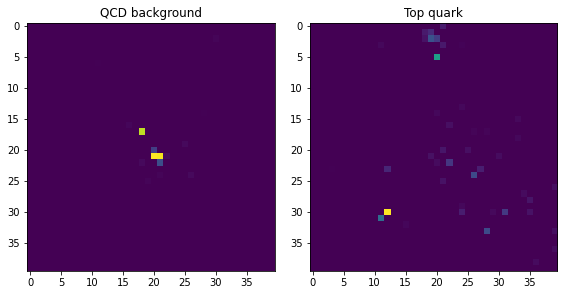

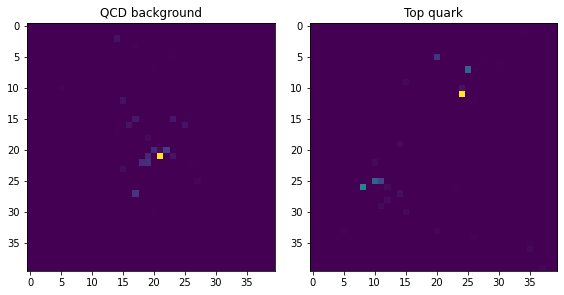

In [13]:
for i in range(2):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("QCD background")
    plt.imshow(qcd_images[i])
    plt.subplot(1, 2, 2)
    plt.title("Top quark")
    plt.imshow(top_images[i])
    plt.tight_layout()
    plt.show()

Notice how the background events are much more clustered around the centre, while the top-quark jets have multiple "prongs". We can see this more clearly by averaging the pixel values across all events:

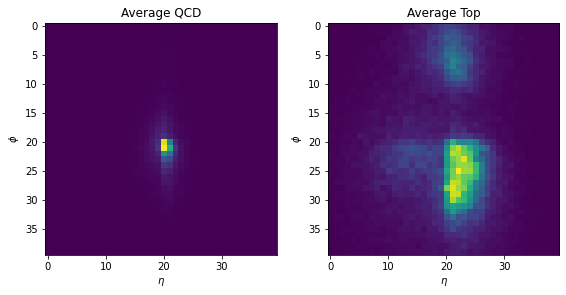

In [14]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(np.sum(qcd_images, axis=0))
plt.title("Average QCD")
plt.xlabel("$\eta$")
plt.ylabel("$\phi$")

plt.subplot(1, 2, 2)
plt.imshow(np.sum(top_images, axis=0))
plt.title("Average Top")
plt.xlabel("$\eta$")
plt.ylabel("$\phi$")

plt.tight_layout()
plt.show()

Great, we now have a way to convert raw 4-vectors into jet images! For convenience, we've applied the above steps to the whole `top_tagging` dataset, so let's download it now:

In [15]:
images_ds = load_dataset("dl4phys/top_tagging_images")
images_ds

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 403000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 404000
    })
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1211000
    })
})

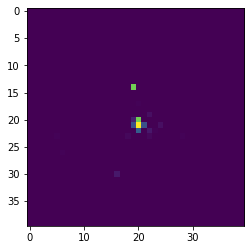

In [19]:
img = images_ds["train"][0]["image"]
plt.imshow(img);

## From images to tensors

Now that we have a dataset of images, the next thing we need to do is convert them to PyTorch tensors and wrap them in a `DataLoader`. One way to do this is via `torchvision`'s `ToTensor` class, which converts a PIL image into a tensor as follows:

In [22]:
t = ToTensor()(img)
t.shape

torch.Size([1, 40, 40])

Here we can see that we now have a tensor of shape `(num_channels, height, width)`, where `num_channels` is 1 because we're dealing with black and white images. 

In [53]:
def get_dataset(dataset, num_examples=None):
    if num_examples is not None:
        dataset = dataset.shuffle(seed=42).select(range(num_examples))

    x = torch.cat([ToTensor()(img) for img in dataset["image"]]).unsqueeze(1)
    y = torch.cat([torch.tensor(l).unsqueeze(0) for l in dataset["label"]])

    return TensorDataset(x, y)

In [76]:
train_ds = get_dataset(images_ds["train"], 500_000)
valid_ds = get_dataset(images_ds["validation"], 50_000)

In [78]:
train_dl = DataLoader(train_ds, bs=128, shuffle=True)
valid_dl = DataLoader(valid_ds, bs=128)

In [79]:
dls = DataLoaders(train_dl, valid_dl)

## Training a CNN

In [ ]:
dls.to("cuda");

In [81]:
learn = vision_learner(
    dls,
    resnet34,
    metrics=[accuracy, RocAucBinary()],
    n_in=1,
    n_out=2,
    normalize=False,
    loss_func=F.cross_entropy,
)

In [82]:
learn.model.to("cuda");

SuggestedLRs(valley=0.0012022644514217973)

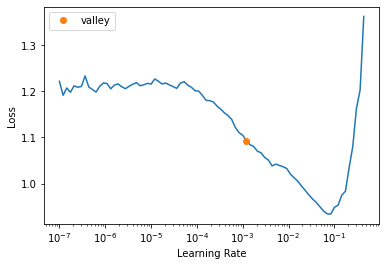

In [83]:
learn.lr_find()

In [84]:
learn.fine_tune(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.320922,0.304875,0.871600,0.941209,01:15


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.241961,0.235067,0.902800,0.965104,01:37
1,0.208062,0.219872,0.909400,0.969319,01:37
2,0.203698,0.215279,0.911520,0.970384,01:37


## Sharing our model

In [85]:
user_or_org = "dl4phys"  # This can also be your Hub username, e.g. lewtun
model_id = "lewtun-resnet-finetuned-images-500k"  # Change this to something different
repo_id = f"{user_or_org}/{model_id}"

push_to_hub_fastai(
    learner=learn,
    repo_id=repo_id,
    commit_message="Add new Learner",
)

Cloning https://huggingface.co/dl4phys/lewtun-resnet-finetuned-images-500k into local empty directory.


AttributeError: 'TensorDataset' object has no attribute 'new_empty'

## Comparisons to other techniques

In [ ]:
xb, yb =

In [44]:
%%time
# train_x[:256]

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs


In [73]:
# %%time
# images_ds["train"][:256]

## Using dataset

In [68]:
num_samples = 100_000

In [47]:
def convert_to_tensor(x):
    x["pixel_values"] = [transforms.ToTensor()(img) for img in x["image"]]
    x["label"] = [torch.tensor(l).unsqueeze(0) for l in x["label"]]
    return x

In [48]:
images_ds = images_ds.map(convert_to_tensor, batched=True, num_proc=4)

Loading cached processed dataset at /home/lewis/.cache/huggingface/datasets/dl4phys___parquet/dl4phys--top_landscape_images-9b271235338645d2/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-b450dc0c83c1a67f.arrow


Loading cached processed dataset at /home/lewis/.cache/huggingface/datasets/dl4phys___parquet/dl4phys--top_landscape_images-9b271235338645d2/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-3089ed3cd2c7fa57.arrow


Loading cached processed dataset at /home/lewis/.cache/huggingface/datasets/dl4phys___parquet/dl4phys--top_landscape_images-9b271235338645d2/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-8fe848766b132ddd.arrow


Loading cached processed dataset at /home/lewis/.cache/huggingface/datasets/dl4phys___parquet/dl4phys--top_landscape_images-9b271235338645d2/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-60be1454cd6c9d7f.arrow


Loading cached processed dataset at /home/lewis/.cache/huggingface/datasets/dl4phys___parquet/dl4phys--top_landscape_images-9b271235338645d2/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-59f55e7e7bbca34e.arrow


Loading cached processed dataset at /home/lewis/.cache/huggingface/datasets/dl4phys___parquet/dl4phys--top_landscape_images-9b271235338645d2/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-a7acaed6da4dcf15.arrow


Loading cached processed dataset at /home/lewis/.cache/huggingface/datasets/dl4phys___parquet/dl4phys--top_landscape_images-9b271235338645d2/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-2c763458767ff94d.arrow


Loading cached processed dataset at /home/lewis/.cache/huggingface/datasets/dl4phys___parquet/dl4phys--top_landscape_images-9b271235338645d2/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-74c910ef6cfcaa80.arrow


Loading cached processed dataset at /home/lewis/.cache/huggingface/datasets/dl4phys___parquet/dl4phys--top_landscape_images-9b271235338645d2/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-407546ab9ed0b964.arrow


Loading cached processed dataset at /home/lewis/.cache/huggingface/datasets/dl4phys___parquet/dl4phys--top_landscape_images-9b271235338645d2/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-f9ab346ca267a70b.arrow


Loading cached processed dataset at /home/lewis/.cache/huggingface/datasets/dl4phys___parquet/dl4phys--top_landscape_images-9b271235338645d2/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-dcb953e4638b49e6.arrow


Loading cached processed dataset at /home/lewis/.cache/huggingface/datasets/dl4phys___parquet/dl4phys--top_landscape_images-9b271235338645d2/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-b7045a46fe6e586f.arrow


In [49]:
images_ds = images_ds.remove_columns("image")

In [69]:
images_ds

DatasetDict({
    validation: Dataset({
        features: ['label', 'pixel_values'],
        num_rows: 403000
    })
    test: Dataset({
        features: ['label', 'pixel_values'],
        num_rows: 404000
    })
    train: Dataset({
        features: ['label', 'pixel_values'],
        num_rows: 1211000
    })
})

In [70]:
class JetImageDataset(Dataset):
    def __init__(self, ds):
        self.ds = ds

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        data = self.ds[idx]
        image = torch.tensor(data["pixel_values"])
        label = torch.tensor(data["label"]).squeeze()
        # image = self.ds[idx]["pixel_values"]
        # label = self.ds[idx]["label"]
        return image, label

In [52]:
# %%time
# for i in images_ds["train"].select(range(num_samples)):
#     _ = i

In [71]:
train_ds = JetImageDataset(images_ds["train"].select(range(num_samples)))
valid_ds = JetImageDataset(images_ds["validation"])

In [54]:
train_dl = DataLoader(
    train_ds,
    bs=256,
    shuffle=True,
)
valid_dl = DataLoader(valid_ds, bs=128)

In [55]:
%time
for xb, yb in train_dl:
    _ = 1

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs


In [56]:
train_dl = DataLoader(train_ds, bs=256, shuffle=True, num_workers=1, pin_memory=True)
train_dl.to("cuda");

In [21]:
%time
for xb, yb in train_dl:
    _ = 1

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [15]:
len(train_ds)

10000

In [8]:
train_ds[0][0].device

device(type='cpu')

In [72]:
train_dl = DataLoader(
    train_ds,
    bs=256,
    # shuffle=True,
)
valid_dl = DataLoader(valid_ds, bs=128)

In [72]:
train_dl.to("cuda")
valid_dl.to("cuda");

In [58]:
xb, yb = first(train_dl)

In [59]:
xb.shape, yb.shape

(torch.Size([256, 1, 40, 40]), torch.Size([256]))

In [73]:
dls = DataLoaders(train_dl, valid_dl)
dls.to("cuda");

In [74]:
learn = vision_learner(
    dls,
    resnet18,
    metrics=[accuracy],
    n_in=1,
    n_out=2,
    normalize=False,
    loss_func=F.cross_entropy,
)

In [75]:
learn.model.to("cuda");

In [76]:
xb, yb = first(dls.loaders[0])

In [77]:
xb.device

device(type='cuda', index=0)

In [78]:
learn.model(xb).device

device(type='cuda', index=0)

SuggestedLRs(valley=0.0012022644514217973)

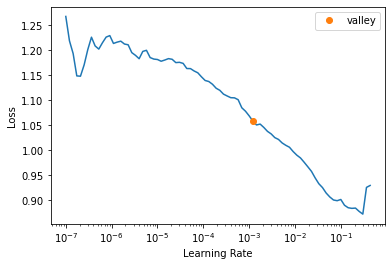

In [79]:
learn.lr_find()

In [80]:
learn.fine_tune(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.514728,0.425086,0.809208,05:41


epoch,train_loss,valid_loss,accuracy,time
0,0.328901,0.292307,0.877146,05:49


## Train simple convnet

In [5]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks // 2)
    if act:
        res = nn.Sequential(res, nn.ReLU())
    return res

In [64]:
simple_cnn = nn.Sequential(
    conv(1, 4),
    conv(4, 8),
    conv(8, 16),
    conv(16, 32),
    conv(32, 16),
    conv(16, 2, act=False),
    Flatten(),
).to("cuda")

In [65]:
simple_cnn(xb).shape

torch.Size([128, 2])

In [66]:
learn = Learner(
    dls, simple_cnn, metrics=[accuracy, RocAucBinary()], loss_func=F.cross_entropy
)

In [67]:
learn.summary()

Sequential (Input shape: 128 x 1 x 40 x 40)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 4 x 20 x 20   
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     128 x 8 x 10 x 10   
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     128 x 16 x 5 x 5    
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     128 x 32 x 3 x 3    
Conv2d                                    4640       True      
ReLU                                         

SuggestedLRs(valley=0.0030199517495930195)

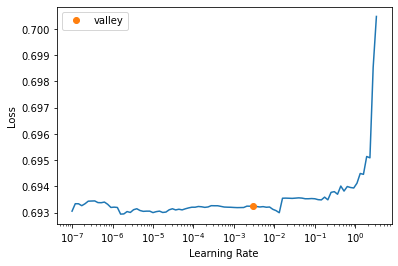

In [68]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 3e-3)

## Train with tensors

In [13]:
num_samples = 10_000

In [14]:
train_ds = images_ds["train"].shuffle()

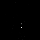

In [15]:
images = train_ds[:num_samples]["image"]
images[0]

In [16]:
labels = train_ds[:num_samples]["label"]

In [17]:
train_x = torch.cat([transforms.ToTensor()(img) for img in images]).unsqueeze(1)
train_y = torch.cat([torch.tensor(l) for l in labels])

In [18]:
train_x.shape, train_y.shape

(torch.Size([10000, 1, 40, 40]), torch.Size([10000]))

In [19]:
class JetTensorDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [20]:
train_ds = JetTensorDataset(train_x, train_y)

In [21]:
# train_ds = TensorDataset(train_x, train_y)

In [22]:
train_dl = DataLoader(train_ds, bs=256, shuffle=True)

In [23]:
%%time
for xb, yb in train_dl:
    _ = 1

CPU times: user 57.5 ms, sys: 139 µs, total: 57.7 ms
Wall time: 56.5 ms


In [24]:
len(train_ds)

10000

In [30]:
%%time
for i in train_ds:
    _ = i

CPU times: user 31.2 ms, sys: 29 µs, total: 31.2 ms
Wall time: 30.7 ms


In [25]:
valid_ds = images_ds["validation"].shuffle()
valid_images = valid_ds[:num_samples]["image"]
valid_labels = valid_ds[:num_samples]["label"]

In [26]:
valid_x = torch.cat([transforms.ToTensor()(img) for img in valid_images]).unsqueeze(1)
valid_y = torch.cat([torch.tensor(l) for l in valid_labels])

In [100]:
valid_y[0]

tensor(0)

In [27]:
# valid_ds = TensorDataset(valid_x, valid_y)
valid_ds = JetTensorDataset(valid_x, valid_y)

In [28]:
train_dl = DataLoader(train_ds, bs=256, shuffle=True)
valid_dl = DataLoader(valid_ds, bs=256, shuffle=False)

In [29]:
xb, yb = first(train_dl)
xb.shape

torch.Size([256, 1, 40, 40])

In [30]:
dls = DataLoaders(train_dl, valid_dl)

### Vision learner

In [31]:
dls.to("cuda");

In [32]:
learn = vision_learner(
    dls,
    resnet34,
    metrics=[accuracy],
    n_in=1,
    n_out=2,
    normalize=False,
    loss_func=F.cross_entropy,
)

In [33]:
learn.model.to("cuda");

SuggestedLRs(valley=0.0012022644514217973)

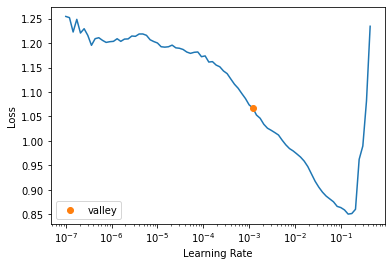

In [34]:
learn.lr_find()

In [ ]:
learn.fine_tune(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.931976,0.669548,0.673500,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.586326,0.497514,0.781100,00:02
1,0.458937,0.431846,0.846900,00:01
2,0.338561,0.415701,0.849700,00:01


In [22]:
simple_cnn = nn.Sequential(
    conv(1, 4),
    conv(4, 8),
    conv(8, 16),
    conv(16, 32),
    conv(32, 16),
    conv(16, 2, act=False),
    Flatten(),
)

In [23]:
simple_cnn(xb).shape

torch.Size([256, 2])

In [27]:
learn = Learner(
    dls, simple_cnn, metrics=[accuracy, RocAucBinary()], loss_func=F.cross_entropy
)

SuggestedLRs(valley=0.0014454397605732083)

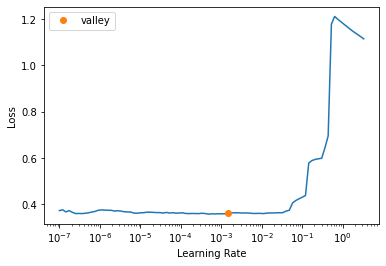

In [28]:
learn.lr_find()

In [29]:
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.310150,0.288318,0.879700,0.950156,00:02
1,0.268565,0.262153,0.889400,0.957021,00:02
2,0.257706,0.252610,0.895000,0.959556,00:02


In [29]:
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.310150,0.288318,0.879700,0.950156,00:02
1,0.268565,0.262153,0.889400,0.957021,00:02
2,0.257706,0.252610,0.895000,0.959556,00:02


In [30]:
learn = Learner(
    dls, simple_cnn, metrics=[accuracy, RocAucBinary()], loss_func=F.cross_entropy
)

In [32]:
learn.model.to("cuda");

SuggestedLRs(valley=0.0008317637839354575)

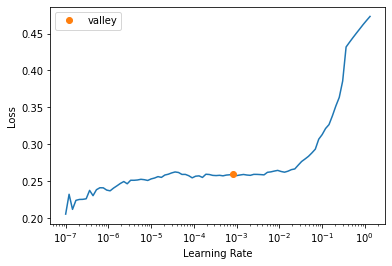

In [33]:
learn.lr_find()

In [34]:
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.262769,0.260341,0.891300,0.959669,00:02
1,0.257183,0.246424,0.898000,0.961613,00:01
2,0.245404,0.241712,0.901200,0.962873,00:01
